# Setup & Import Library

In [1]:
%pip install -q -U langchain-google-genai

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity

In [3]:
from IPython.display import display, HTML, clear_output
import ipywidgets as widgets
from difflib import get_close_matches

In [4]:
from pydantic import BaseModel, Field
from langchain_core.output_parsers import PydanticOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnableSequence
from langchain_google_genai import ChatGoogleGenerativeAI

In [5]:
import logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

In [6]:
import getpass, os

if "GOOGLE_API_KEY" not in os.environ:
    os.environ["GOOGLE_API_KEY"] = getpass.getpass("Enter your Google AI API key: ")

# Load Data

In [7]:
# Load Data dari URL
url = "https://drive.google.com/file/d/173cJmcwkC8dnlnvoXbDQ-1ZTVVAjtiMX/view?usp=drive_link"

# Deteksi file ID dari link Google Drive
match = re.search(r"/d/([a-zA-Z0-9_-]+)", url)

if match:
    file_id = match.group(1)
    url = f"https://drive.google.com/uc?export=download&id={file_id}"
else:
    raise ValueError("Link Google Drive tidak valid!")

print("Download URL:", url)

# Load CSV dari Google Drive
df = pd.read_csv(url)

print("Dataset berhasil dimuat! ✅")
print("Ukuran dataset:", df.shape)
print("\nBeberapa baris pertama:")
display(df.head())

print("\nInformasi kolom:")
df.info()

Download URL: https://drive.google.com/uc?export=download&id=173cJmcwkC8dnlnvoXbDQ-1ZTVVAjtiMX
Dataset berhasil dimuat! ✅
Ukuran dataset: (4090, 11)

Beberapa baris pertama:


,Unnamed: 0,ID,ProdID,Rating,ReviewCount,Category,Brand,Name,ImageURL,Description,Tags
0,0,1705736792,2,0.0,0.0,"premium, beauty, premium, makeup, premium, nai...",opi,"OPI Infinite Shine, Nail Lacquer Nail Polish, ...",https://i5.walmartimages.com/asr/0e1f4c51-c1a4...,NaN,"premium, beauty, premium, makeup, premium, nai..."
1,1,95,76,0.0,0.0,"beauty, hair, care, hair, color, auburn, hair,...",easy,"Nice n Easy Permanent Color, 111 Natural Mediu...",https://i5.walmartimages.com/asr/9c8e42e4-13a5...,"pack, 3, pack, 3, upc, 381519000201, beautiful...","beauty, hair, care, hair, color, auburn, hair,..."
2,2,8,8,4.5,29221.0,"beauty, hair, care, hair, color, permanent, ha...",clairol,Clairol Nice N Easy Permanent Color 7/106A Nat...,https://i5.walmartimages.com/asr/e3a601c2-6a2b...,"clairol, nice, n, easy, permanent, color, give...","beauty, hair, care, hair, color, permanent, ha..."
3,3,4,3,0.0,0.0,"beauty, makeup, lip","kokie, cosmetics","Kokie Professional Matte Lipstick, Hot Berry, ...",https://i5.walmartimages.com/asr/25b4b467-bc61...,"calling, matte, lip, lovers, indulge, rich, cr...","beauty, makeup, lip, kokie, cosmetics, calling..."
4,4,990,3,0.0,131.0,"seasonal, stock, essentials, personal, care, s...",gillette,"Gillette TRAC II Plus Razor Blade Refills, Fit...",https://i5.walmartimages.com/asr/1a2ebb06-cd01...,"1971, gillette, introduced, trac, ii, razor, s...","seasonal, stock, essentials, personal, care, s..."



Informasi kolom:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4090 entries, 0 to 4089
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   4090 non-null   int64  
 1   ID           4090 non-null   int64  
 2   ProdID       4090 non-null   int64  
 3   Rating       4090 non-null   float64
 4   ReviewCount  4090 non-null   float64
 5   Category     4081 non-null   object 
 6   Brand        3994 non-null   object 
 7   Name         4090 non-null   object 
 8   ImageURL     4090 non-null   object 
 9   Description  3174 non-null   object 
 10  Tags         4090 non-null   object 
dtypes: float64(2), int64(3), object(6)
memory usage: 351.6+ KB


# Pre-Processing

In [8]:
# Data Cleaning
print("Cek missing values:")
display(df.isnull().sum())

# Handling Missing Value

# Isi atau hapus nilai kosong
df['Rating'] = df['Rating'].fillna(df['Rating'].mean())
df['ReviewCount'] = df['ReviewCount'].fillna(0)
df['Description'] = df['Description'].fillna('')
df['Tags'] = df['Tags'].fillna('')
df['Name'] = df['Name'].fillna('')
df['Category'] = df['Category'].fillna('Unknown')
df['Brand'] = df['Brand'].fillna('Unknown')

# Hapus duplikat berdasarkan ProdID
df = df.drop_duplicates(subset=['ProdID'])

print("\nData setelah cleaning:")
print(df.shape)
display(df.head())

# Pembersihan Rating
# Ganti rating 0 jadi NaN
df['Rating'] = df['Rating'].replace(0, np.nan)

# Isi NaN dengan rata-rata rating per produk (berdasarkan kolom 'ProductID' misalnya)
# Kalau tidak ada kolom 'ProductID', ganti dengan kolom yang mewakili produk unik
df['Rating'] = df.groupby('Brand')['Rating'].transform(lambda x: x.fillna(x.mean()))

# Kalau masih ada NaN (misal karena seluruh rating produk itu 0 sebelumnya), isi dengan rata-rata global
df['Rating'] = df['Rating'].fillna(df['Rating'].mean())

# Pemeriksaan ulang
print("\nCek missing values setelah cleaning:")
display(df.isnull().sum())

Cek missing values:


Unnamed: 0       0
ID               0
ProdID           0
Rating           0
ReviewCount      0
Category         9
Brand           96
Name             0
ImageURL         0
Description    916
Tags             0
dtype: int64


Data setelah cleaning:
(1607, 11)


,Unnamed: 0,ID,ProdID,Rating,ReviewCount,Category,Brand,Name,ImageURL,Description,Tags
0,0,1705736792,2,0.0,0.0,"premium, beauty, premium, makeup, premium, nai...",opi,"OPI Infinite Shine, Nail Lacquer Nail Polish, ...",https://i5.walmartimages.com/asr/0e1f4c51-c1a4...,,"premium, beauty, premium, makeup, premium, nai..."
1,1,95,76,0.0,0.0,"beauty, hair, care, hair, color, auburn, hair,...",easy,"Nice n Easy Permanent Color, 111 Natural Mediu...",https://i5.walmartimages.com/asr/9c8e42e4-13a5...,"pack, 3, pack, 3, upc, 381519000201, beautiful...","beauty, hair, care, hair, color, auburn, hair,..."
2,2,8,8,4.5,29221.0,"beauty, hair, care, hair, color, permanent, ha...",clairol,Clairol Nice N Easy Permanent Color 7/106A Nat...,https://i5.walmartimages.com/asr/e3a601c2-6a2b...,"clairol, nice, n, easy, permanent, color, give...","beauty, hair, care, hair, color, permanent, ha..."
3,3,4,3,0.0,0.0,"beauty, makeup, lip","kokie, cosmetics","Kokie Professional Matte Lipstick, Hot Berry, ...",https://i5.walmartimages.com/asr/25b4b467-bc61...,"calling, matte, lip, lovers, indulge, rich, cr...","beauty, makeup, lip, kokie, cosmetics, calling..."
5,5,262,-2147483648,4.6,52.0,"beauty, hair, care, hair, care, brands, old, s...","old, spice",Old Spice Artisan Styling High Hold Matte Fini...,https://i5.walmartimages.com/asr/73214b95-72ce...,"old, spice, artisan, molding, clay, mens, styl...","beauty, hair, care, hair, care, brands, old, s..."



Cek missing values setelah cleaning:


Unnamed: 0     0
ID             0
ProdID         0
Rating         0
ReviewCount    0
Category       0
Brand          0
Name           0
ImageURL       0
Description    0
Tags           0
dtype: int64

# Exploratory Data Analysis (EDA)

Informasi Dataset Setelah Cleaning:
Jumlah Baris: 1607
Jumlah Kolom: 11

Tipe Data Tiap Kolom:


Unnamed: 0       int64
ID               int64
ProdID           int64
Rating         float64
ReviewCount    float64
Category        object
Brand           object
Name            object
ImageURL        object
Description     object
Tags            object
dtype: object


Cek Nilai Kosong:


Unnamed: 0     0
ID             0
ProdID         0
Rating         0
ReviewCount    0
Category       0
Brand          0
Name           0
ImageURL       0
Description    0
Tags           0
dtype: int64


Preview Data:


,Unnamed: 0,ID,ProdID,Rating,ReviewCount,Category,Brand,Name,ImageURL,Description,Tags
0,0,1705736792,2,4.03125,0.0,"premium, beauty, premium, makeup, premium, nai...",opi,"OPI Infinite Shine, Nail Lacquer Nail Polish, ...",https://i5.walmartimages.com/asr/0e1f4c51-c1a4...,,"premium, beauty, premium, makeup, premium, nai..."
1,1,95,76,5.00000,0.0,"beauty, hair, care, hair, color, auburn, hair,...",easy,"Nice n Easy Permanent Color, 111 Natural Mediu...",https://i5.walmartimages.com/asr/9c8e42e4-13a5...,"pack, 3, pack, 3, upc, 381519000201, beautiful...","beauty, hair, care, hair, color, auburn, hair,..."
2,2,8,8,4.50000,29221.0,"beauty, hair, care, hair, color, permanent, ha...",clairol,Clairol Nice N Easy Permanent Color 7/106A Nat...,https://i5.walmartimages.com/asr/e3a601c2-6a2b...,"clairol, nice, n, easy, permanent, color, give...","beauty, hair, care, hair, color, permanent, ha..."


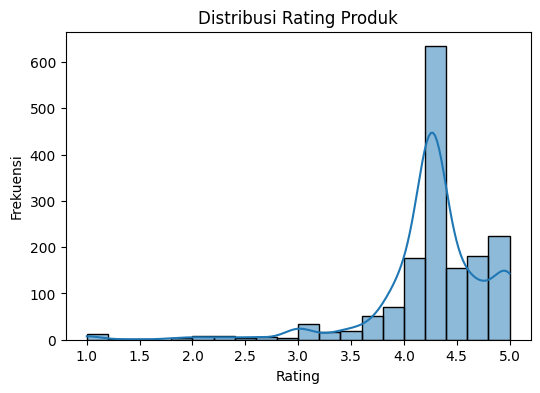

Rata-rata rating: 4.27
Rating tertinggi: 5.0
Rating terendah: 1.0


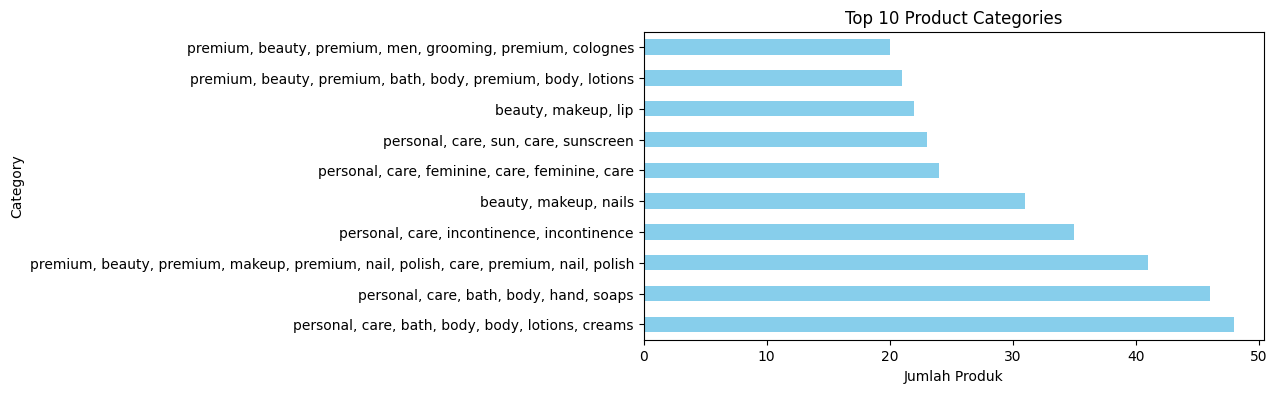

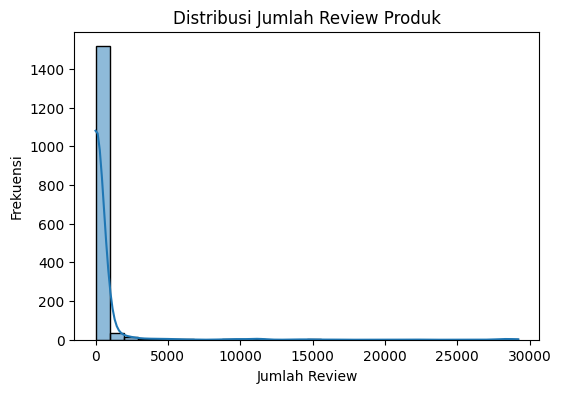

Rata-rata review: 401.57
Maksimum review: 29221.0


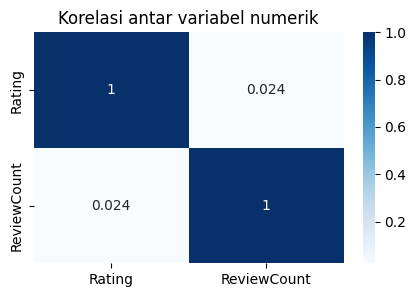

In [9]:
# Exploratory Data Analysis (EDA)
print("Informasi Dataset Setelah Cleaning:")
print("Jumlah Baris:", df.shape[0])
print("Jumlah Kolom:", df.shape[1])
print("\nTipe Data Tiap Kolom:")
display(df.dtypes)

print("\nCek Nilai Kosong:")
display(df.isnull().sum())

print("\nPreview Data:")
display(df.head(3))

# --- Lanjutkan ke EDA ---
plt.figure(figsize=(6,4))
sns.histplot(df['Rating'], bins=20, kde=True)
plt.title("Distribusi Rating Produk")
plt.xlabel("Rating")
plt.ylabel("Frekuensi")
plt.show()

print("Rata-rata rating:", round(df['Rating'].mean(), 2))
print("Rating tertinggi:", df['Rating'].max())
print("Rating terendah:", df['Rating'].min())

# Top 10 kategori
plt.figure(figsize=(8,4))
df['Category'].value_counts().head(10).plot(kind='barh', color='skyblue')
plt.title("Top 10 Product Categories")
plt.xlabel("Jumlah Produk")
plt.ylabel("Category")
plt.show()

# Distribusi Jumlah Review
plt.figure(figsize=(6,4))
sns.histplot(df['ReviewCount'], bins=30, kde=True)
plt.title("Distribusi Jumlah Review Produk")
plt.xlabel("Jumlah Review")
plt.ylabel("Frekuensi")
plt.show()

print("Rata-rata review:", round(df['ReviewCount'].mean(), 2))
print("Maksimum review:", df['ReviewCount'].max())

# Korelasi Antar Nilai Numerik
plt.figure(figsize=(5,3))
sns.heatmap(df[['Rating','ReviewCount']].corr(), annot=True, cmap='Blues')
plt.title("Korelasi antar variabel numerik")
plt.show()

# Feature Engineering

In [10]:
# FEATURE ENGINEERING
# Cek & isi missing value penting
df['Brand'] = df['Brand'].fillna('Unknown')
df['Category'] = df['Category'].fillna('Miscellaneous')
df['Rating'] = df['Rating'].fillna(df['Rating'].mean())
df['ReviewCount'] = df['ReviewCount'].fillna(0)
df['Description'] = df['Description'].fillna('')
df['Tags'] = df['Tags'].fillna('')
df['Name'] = df['Name'].fillna('')

# Gabungkan semua kolom teks jadi satu
df['text_features'] = (
    df['Name'] + ' ' +
    df['Description'] + ' ' +
    df['Tags'] + ' ' +
    df['Brand'] + ' ' +
    df['Category']
)

# TF-IDF vectorization untuk fitur teks
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
tfidf_matrix = vectorizer.fit_transform(df['text_features'])
print("TF-IDF matrix:", tfidf_matrix.shape)

# Normalisasi nilai numerik (rating & review count)
scaler = MinMaxScaler()
df[['Rating_scaled', 'ReviewCount_scaled']] = scaler.fit_transform(
    df[['Rating', 'ReviewCount']]
)

# Ringkasan hasil
print("\nRingkasan Kolom Baru:")
print(df[['Rating_scaled','ReviewCount_scaled']].head(3))
print("\nKolom dataset:", list(df.columns))
print("\nCek 2 data acak:")
display(df.sample(5))

TF-IDF matrix: (1607, 5000)

Ringkasan Kolom Baru:
   Rating_scaled  ReviewCount_scaled
0       0.757812                 0.0
1       1.000000                 0.0
2       0.875000                 1.0

Kolom dataset: ['Unnamed: 0', 'ID', 'ProdID', 'Rating', 'ReviewCount', 'Category', 'Brand', 'Name', 'ImageURL', 'Description', 'Tags', 'text_features', 'Rating_scaled', 'ReviewCount_scaled']

Cek 2 data acak:


,Unnamed: 0,ID,ProdID,Rating,ReviewCount,Category,Brand,Name,ImageURL,Description,Tags,text_features,Rating_scaled,ReviewCount_scaled
3833,4637,3594,9403274,4.400000,377.0,"personal, care, restock, save, hair, care, hai...","carol, daughter",($23 Value) Carols Daughter Black Vanilla Cond...,https://i5.walmartimages.com/asr/5e0dcc63-2275...,"hair, moisture, need, holiday, season, carols,...","personal, care, restock, save, hair, care, hai...",($23 Value) Carols Daughter Black Vanilla Cond...,0.850000,0.012902
1195,1316,68,692,4.600000,280.0,"household, essentials, cleaning, supplies, dis...",dawn,"Dawn Ultra Liquid Dish Soap, Apple Blossom Sce...",https://i5.walmartimages.com/asr/e6969bbd-6858...,"think, dish, soaps, think, dawn, ultra, 2x, gr...","household, essentials, cleaning, supplies, dis...","Dawn Ultra Liquid Dish Soap, Apple Blossom Sce...",0.900000,0.009582
1662,1869,40,4176,4.265998,500.0,"household, essentials, paper, plastic, trash, ...",glad,"Glad Tall Kitchen Trash Bags, 13 Gallon, 40 Ba...",https://i5.walmartimages.com/asr/6bc74ad6-ffe8...,"fight, nasty, kitchen, odors, glad, trash, bag...","household, essentials, paper, plastic, trash, ...","Glad Tall Kitchen Trash Bags, 13 Gallon, 40 Ba...",0.816499,0.017111
2955,3517,94,6378,4.900000,0.0,"personal, care, bath, body, hand, soaps","clearly, natural",Clearly Natural Liquid Pump Soap Refill Unscen...,https://i5.walmartimages.com/asr/9c6e8fd3-e02d...,"clearly, natural, liquid, pump, soap, refill, ...","personal, care, bath, body, hand, soaps, clear...",Clearly Natural Liquid Pump Soap Refill Unscen...,0.975000,0.000000
3640,4389,1,76998,4.265998,0.0,"personal, care, bath, body, hand, soaps",gojo,Gojo Ultra Mild Lotion Soap w/Chloroxylenol Re...,https://i5.walmartimages.com/asr/18019056-ec33...,"ultra, mild, lotion, soap, w, chloroxylenol, r...","personal, care, bath, body, hand, soaps, gojo,...",Gojo Ultra Mild Lotion Soap w/Chloroxylenol Re...,0.816499,0.000000


# Modelling

In [11]:
# HYBRID RECOMMENDER SYSTEM (FIXED)
# Pastikan index df berurutan mulai dari 0
df = df.reset_index(drop=True)

# Ubah skala ReviewCount supaya distribusinya lebih seimbang
df['review_log'] = np.log1p(df['ReviewCount'])
df['review_norm'] = df['review_log'] / df['review_log'].max()

# Scaling numeric features
scaler = MinMaxScaler()
df['Rating_scaled'] = scaler.fit_transform(df[['Rating']])
df['ReviewCount_scaled'] = scaler.fit_transform(df[['ReviewCount']])

# TF-IDF untuk konten produk
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
tfidf_matrix = vectorizer.fit_transform(
    df['Name'].fillna('') + ' ' +
    df['Description'].fillna('') + ' ' +
    df['Tags'].fillna('') + ' ' +
    df['Category'].fillna('')
)

# Content-based similarity
content_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Numeric similarity
num_features = df[['Rating_scaled', 'ReviewCount_scaled']].values
numeric_sim = cosine_similarity(num_features, num_features)

# Hybrid similarity
hybrid_sim = 0.4 * content_sim + 0.6 * numeric_sim

# Evaluasi Rata-Rata

In [12]:
# Evaluasi rata-rata similarity untuk seluruh produk
results = []
for idx, row in df.iterrows():
    product_name = row['Name']
    sim_scores = list(enumerate(hybrid_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:6]
    avg_sim = np.mean([s[1] for s in sim_scores])
    results.append({
        'Product': product_name,
        'Brand': row['Brand'],
        'Category': row['Category'],
        'Average_Similarity': avg_sim
    })

df_similarity_eval = pd.DataFrame(results).sort_values(by='Average_Similarity', ascending=False)
display(df_similarity_eval.head(10))

,Product,Brand,Category,Average_Similarity
658,"OPI Nail Polish, Nothin Mousie, 0.5 Fl Oz",opi,"premium, beauty, premium, makeup, premium, nai...",0.995140
1333,"OPI Nail Polish, Are We There Yet?, 0.5 Fl Oz",opi,"premium, beauty, premium, makeup, premium, nai...",0.995138
1249,"Coty OPI Nail Lacquer, 0.5 oz",opi,"premium, beauty, premium, makeup, premium, nai...",0.992627
1300,Giorgio Armani Emporio Armani Diamonds Eau De ...,"giorgio, armani","premium, beauty, premium, men, grooming, premi...",0.992510
958,Prada 535823 1.7 oz L Homme by Prada Eau De To...,prada,"premium, beauty, premium, men, grooming, premi...",0.992510
931,Salvatore Ferragamo Acqua Essenziale Eau De To...,"salvatore, ferragamo","premium, beauty, premium, men, grooming, premi...",0.992510
903,"OPI Nail Polish, Primarily Yellow, 0.5 Fl Oz",opi,"premium, beauty, premium, makeup, premium, nai...",0.992319
1254,OPI Nail Lacquer Polish .5oz/15mL - Ski Slope ...,opi,"premium, beauty, premium, makeup, premium, nai...",0.991031
636,"OPI Nail Polish, Machu Peach-U, 0.5 Fl Oz",opi,"premium, beauty, premium, makeup, premium, nai...",0.990353
1038,"OPI Nail Polish, Happy Anniversary",opi,"premium, beauty, premium, makeup, premium, nai...",0.990250


In [13]:
# Pastikan df dan hybrid_sim punya ukuran sama
print("Jumlah produk di df:", len(df))
print("Ukuran hybrid_sim:", hybrid_sim.shape)

# Kalau berbeda, potong biar sejajar
if len(df) != hybrid_sim.shape[0]:
    df = df.iloc[:hybrid_sim.shape[0]].reset_index(drop=True)

# Evaluasi rata-rata kesamaan untuk seluruh produk
results = []

for idx in range(hybrid_sim.shape[0]):
    product = df.iloc[idx]['Name']
    sim_scores = list(enumerate(hybrid_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:6]  # 5 produk paling mirip
    avg_sim = np.mean([s[1] for s in sim_scores])
    results.append({
        'Product': product,
        'Brand': df.iloc[idx]['Brand'],
        'Category': df.iloc[idx]['Category'],
        'Average_Similarity': avg_sim
    })

# Buat tabel hasil
df_similarity_eval = pd.DataFrame(results).sort_values(by='Average_Similarity', ascending=False)

# Tampilkan tabel 10 teratas
print("🔹 Top 10 Produk dengan Rata-rata Kemiripan Tertinggi (Hybrid Model):")
display(df_similarity_eval.head(10))

# (Opsional) Tampilkan 10 produk dengan kemiripan terendah
print("\n🔹 10 Produk dengan Rata-rata Kemiripan Terendah:")
display(df_similarity_eval.tail(10))

# Statistik global
print("\n📊 Statistik Keseluruhan:")
print(f"Rata-rata keseluruhan similarity: {df_similarity_eval['Average_Similarity'].mean():.4f}")
print(f"Nilai maksimum similarity: {df_similarity_eval['Average_Similarity'].max():.4f}")
print(f"Nilai minimum similarity: {df_similarity_eval['Average_Similarity'].min():.4f}")

Jumlah produk di df: 1607
Ukuran hybrid_sim: (1607, 1607)
🔹 Top 10 Produk dengan Rata-rata Kemiripan Tertinggi (Hybrid Model):


,Product,Brand,Category,Average_Similarity
658,"OPI Nail Polish, Nothin Mousie, 0.5 Fl Oz",opi,"premium, beauty, premium, makeup, premium, nai...",0.995140
1333,"OPI Nail Polish, Are We There Yet?, 0.5 Fl Oz",opi,"premium, beauty, premium, makeup, premium, nai...",0.995138
1249,"Coty OPI Nail Lacquer, 0.5 oz",opi,"premium, beauty, premium, makeup, premium, nai...",0.992627
1300,Giorgio Armani Emporio Armani Diamonds Eau De ...,"giorgio, armani","premium, beauty, premium, men, grooming, premi...",0.992510
958,Prada 535823 1.7 oz L Homme by Prada Eau De To...,prada,"premium, beauty, premium, men, grooming, premi...",0.992510
931,Salvatore Ferragamo Acqua Essenziale Eau De To...,"salvatore, ferragamo","premium, beauty, premium, men, grooming, premi...",0.992510
903,"OPI Nail Polish, Primarily Yellow, 0.5 Fl Oz",opi,"premium, beauty, premium, makeup, premium, nai...",0.992319
1254,OPI Nail Lacquer Polish .5oz/15mL - Ski Slope ...,opi,"premium, beauty, premium, makeup, premium, nai...",0.991031
636,"OPI Nail Polish, Machu Peach-U, 0.5 Fl Oz",opi,"premium, beauty, premium, makeup, premium, nai...",0.990353
1038,"OPI Nail Polish, Happy Anniversary",opi,"premium, beauty, premium, makeup, premium, nai...",0.990250



🔹 10 Produk dengan Rata-rata Kemiripan Terendah:


,Product,Brand,Category,Average_Similarity
1128,Alba Botanica After Sun Gel 98% Aloe Vera 8 Ou...,"alba, botanica","seasonal, clean, living, shop, household, clea...",0.625662
571,Biore Blemish Fighting Ice Cleanser 6.77 oz (P...,bioré,"beauty, skin, care, facial, cleansers, biore, ...",0.623111
513,Earthly Body Edibles | 100% Natural EDIBLE Mas...,"earthly, body","health, aromatherapy, aromatherapy",0.620009
864,"White Rain Moisturizing Shampoo, Apple Blossom...","white, rain","beauty, hair, care, shampoo, shampoo",0.617345
1507,"Replens Long-Lasting Vaginal Moisturizer, 8ct ...",replens,"personal, care, feminine, care, feminine, care",0.615177
192,2Pair Waterproof Rubber Yellow Reusable Cleani...,fymall,"household, essentials, cleaning, supplies, cle...",0.611006
1021,Out Of Africa Shea Butter Tin - Vanilla .5Oz,africa,"personal, care, bath, body, body, lotions, creams",0.608635
1258,"Colgate cavity protection toothpaste, regular,...",colgate,"personal, care, personal, care, brand, colgate",0.607018
828,Sally Hansen Sh Sugar Shimmer Berried Under,"sally, hansen","beauty, makeup, nails",0.602586
645,Biore Combo Pack Deep Cleansing Pore Strips Fa...,bioré,"beauty, skin, care, facial, cleansers, biore, ...",0.073097



📊 Statistik Keseluruhan:
Rata-rata keseluruhan similarity: 0.7798
Nilai maksimum similarity: 0.9951
Nilai minimum similarity: 0.0731


# Visualisasi

🔹 Produk acuan: OPI Infinite Shine, Nail Lacquer Nail Polish, Bubble Bath
🔹 Rata-rata similarity: 0.982


,Name,Brand,Category,Rating,ReviewCount
507,OPI Nail GelColor + Infinite Shine Polish - PR...,opi,"premium, beauty, premium, makeup, premium, nai...",4.03125,0.0
1249,"Coty OPI Nail Lacquer, 0.5 oz",opi,"premium, beauty, premium, makeup, premium, nai...",4.03125,0.0
1110,"OPI Nail Lacquer Nail Polish, Shorts Story",opi,"premium, beauty, premium, makeup, premium, nai...",5.00000,1.0
1333,"OPI Nail Polish, Are We There Yet?, 0.5 Fl Oz",opi,"premium, beauty, premium, makeup, premium, nai...",3.00000,2.0
658,"OPI Nail Polish, Nothin Mousie, 0.5 Fl Oz",opi,"premium, beauty, premium, makeup, premium, nai...",4.40000,57.0


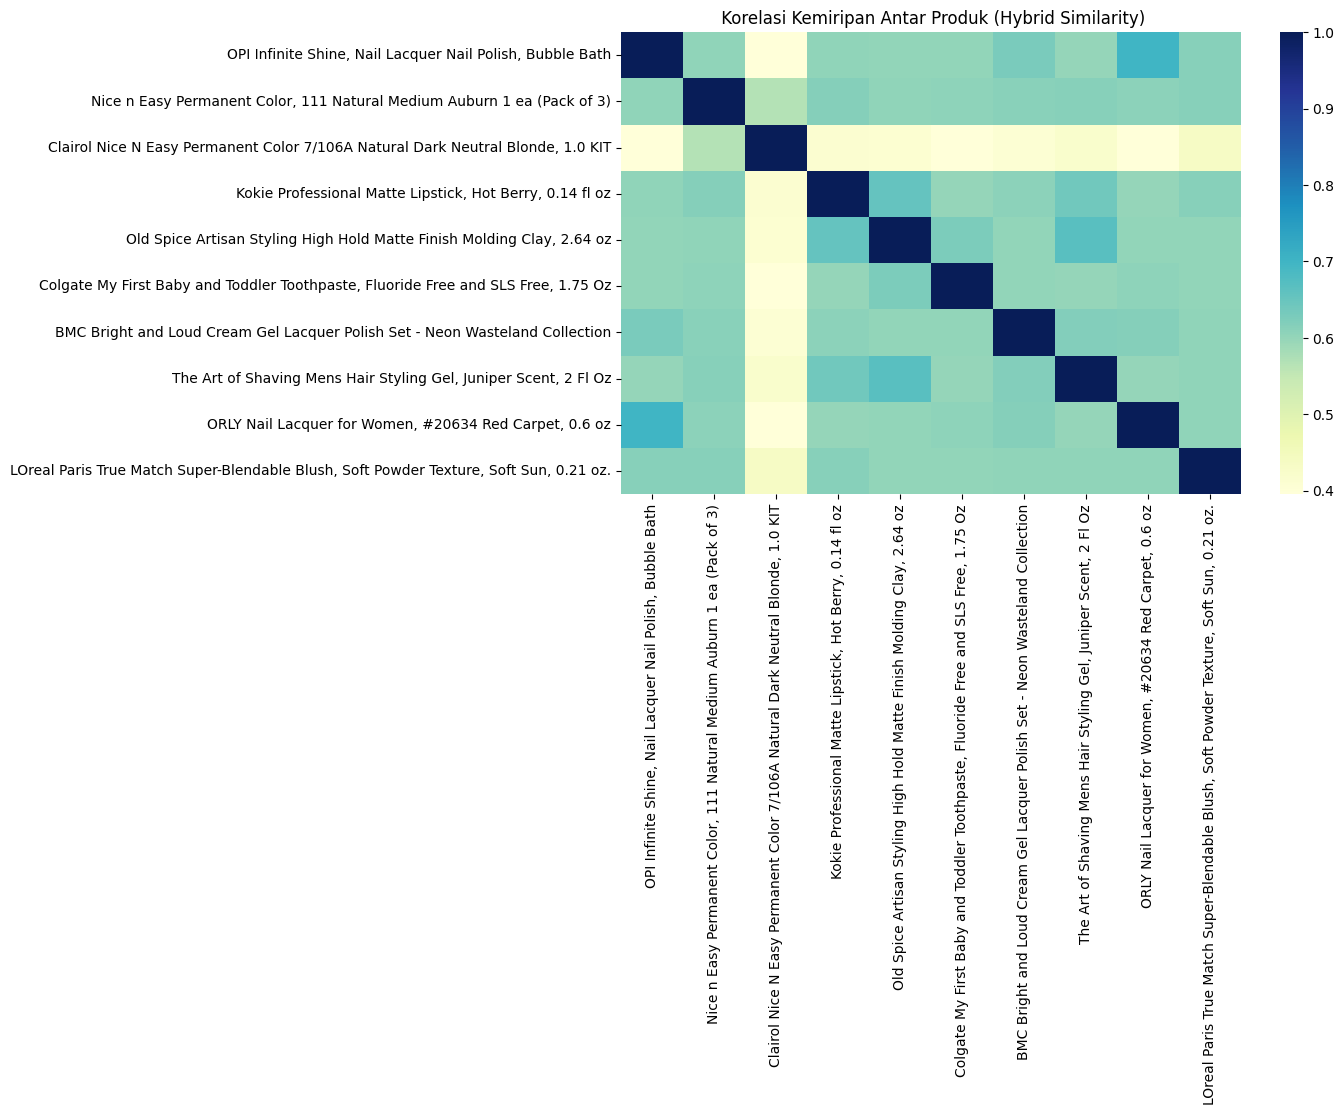

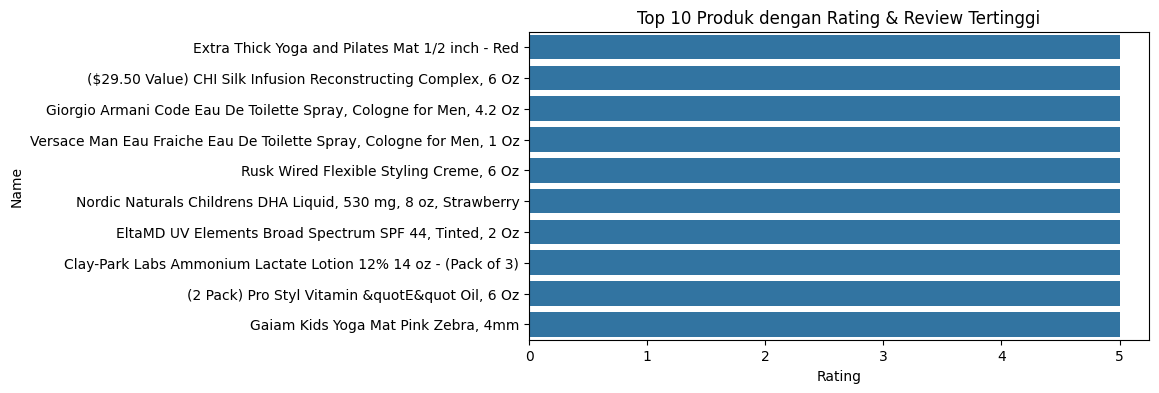

In [14]:
# Visualisasi Hybrid Recommendation
# Evaluasi Kesamaan Produk (OPI Parameter)
def evaluate_recommendations(product_name, n=5):
    if product_name not in df['Name'].values:
        return f"Produk '{product_name}' tidak ditemukan."

    idx = df[df['Name'] == product_name].index[0]
    sim_scores = list(enumerate(hybrid_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:n+1]

    # Hitung rata-rata similarity
    avg_sim = np.mean([s[1] for s in sim_scores])

    # Ambil rekomendasi
    recommended = df.iloc[[i[0] for i in sim_scores]][['Name','Brand','Category','Rating','ReviewCount']]

    print(f"🔹 Produk acuan: {product_name}")
    print(f"🔹 Rata-rata similarity: {avg_sim:.3f}")
    return recommended

# Contoh evaluasi
sample_product = df['Name'].iloc[0]
recommended = evaluate_recommendations(sample_product, n=5)
display(recommended)

# Heatmap Kemiripan Produk (Visualisasi)
plt.figure(figsize=(10,6))
sample_indices = range(10)
sample_names = df['Name'].iloc[sample_indices]
sns.heatmap(
    hybrid_sim[np.ix_(sample_indices, sample_indices)],
    xticklabels=sample_names,
    yticklabels=sample_names,
    cmap='YlGnBu'
)
plt.title(" Korelasi Kemiripan Antar Produk (Hybrid Similarity)")
plt.xticks(rotation=90)
plt.show()

# Analisis Popularitas (Bonus Insight)
top_popular = df.sort_values(by=['Rating','ReviewCount'], ascending=False).head(10)
plt.figure(figsize=(8,4))
sns.barplot(data=top_popular, x='Rating', y='Name')
plt.title("Top 10 Produk dengan Rating & Review Tertinggi")
plt.show()

# UI

In [15]:
# Deployment Hybrid Recommendation System (UI + CLI Mode)
# Fungsi rekomendasi
def hybrid_recommend(product_name, n=5):
    product_name = product_name.strip().lower()
    df['Name_norm'] = df['Name'].str.strip().str.lower()

    # Cari produk mirip
    if product_name not in df['Name_norm'].values:
        matches = df[df['Name_norm'].str.contains(product_name, case=False, na=False)]
        if len(matches) == 0:
            closest = get_close_matches(product_name, df['Name_norm'], n=1, cutoff=0.4)
            if not closest:
                return f"❌ Produk '{product_name}' tidak ditemukan di dataset."
            product_name = closest[0]
            print(f"🔍 Produk tidak ditemukan persis. Menampilkan hasil mirip: {product_name}")
        else:
            product_name = matches['Name_norm'].iloc[0]
            print(f"🔍 Produk mirip ditemukan: {product_name}")

    idx = df[df['Name_norm'] == product_name].index[0]
    sim_scores = list(enumerate(hybrid_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:n+20]  # ambil lebih banyak dulu

    results = df.iloc[[i[0] for i in sim_scores]].copy()
    results['similarity'] = [s[1] for s in sim_scores]

    # Normalisasi rating & review agar 0-1
    results['rating_norm'] = (results['Rating'] - results['Rating'].min()) / (results['Rating'].max() - results['Rating'].min())
    results['review_norm'] = (results['ReviewCount'] - results['ReviewCount'].min()) / (results['ReviewCount'].max() - results['ReviewCount'].min())

    # Skor akhir = kombinasi similarity + rating + review count
    results['final_score'] = (
      0.4 * results['similarity'] +
      0.3 * results['rating_norm'] +
      0.3 * results['review_norm']
    )

    # Urutkan berdasarkan final_score
    results = results.sort_values('final_score', ascending=False)

    # Ambil top-n
    recommended = results[['Name','Brand','Category','Rating','ReviewCount','final_score','Description']].head(n)
    return recommended

# ---- Mode UI (Text Box Colab) ----
input_box = widgets.Text(
    placeholder='Ketik nama produk...',
    description='Produk:',
    layout=widgets.Layout(width='400px')
)
output_area = widgets.Output()
exit_button = widgets.Button(description="Exit", button_style='danger')
clear_button = widgets.Button(description="Clear Output", button_style='warning')

# Event handler
def on_submit(change):
    with output_area:
        clear_output()
        product_name = change['new']
        if not product_name:
            print("Masukkan nama produk untuk melihat rekomendasi.")
            return
        result = hybrid_recommend(product_name, n=10)
        if isinstance(result, str):
            print(result)
        else:
            display(result)

def on_exit_clicked(b):
  with output_area:
      clear_output()
      print("👋 Sistem rekomendasi dihentikan. Terima kasih!")

def on_clear_clicked(b):
  with output_area:
      clear_output()
      print("🧹 Output dibersihkan. Silakan ketik nama produk lagi.")

# Hubungkan event
input_box.observe(on_submit, names='value')
exit_button.on_click(on_exit_clicked)
clear_button.on_click(on_clear_clicked)

# Tampilkan interface
# display(HTML("<h3>🛍️ Hybrid Product Recommender</h3><p>Ketik nama produk untuk melihat rekomendasi miripnya.</p>"))
# display(input_box, widgets.HBox([clear_button, exit_button]), output_area)

# Evaluasi LLM

In [16]:
# Schema output
class HybridEvaluation(BaseModel):
    score: int = Field(..., description="Skor penilaian 1–10")
    description: str = Field(..., description="Deskripsi singkat tentang kualitas rekomendasi")
    reasons: list[str] = Field(..., description="Alasan penilaian")
    summary: str = Field(..., description="Ringkasan keseluruhan evaluasi hybrid")

parser = PydanticOutputParser(pydantic_object=HybridEvaluation)

In [17]:
# Prompt evaluator
prompt = ChatPromptTemplate.from_messages([
    ("system", "Kamu adalah evaluator untuk sistem rekomendasi hybrid."),
    ("human", """
Berikut adalah hasil rekomendasi hybrid:

{rekomendasi}

Tolong lakukan evaluasi dengan format berikut:

1. score = nilai 1–10 untuk kualitas keseluruhan rekomendasi.
2. description = deskripsi singkat (1 paragraf) tentang impresi utama dari hasil rekomendasi.
3. reasons = daftar alasan evaluasi dalam bentuk bullet/poin.
4. summary = ringkasan akhir kualitas hybrid system secara keseluruhan (1 paragraf).

Output HARUS mengikuti format:
{format_instructions}
"""),
])

In [18]:
# Model Gemini
eval_model = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
    temperature=0
)

# Pipeline
evaluation_chain = prompt | eval_model | parser

# Fungsi
def evaluate_recommendation(df_rekom):
    rekom_json = df_rekom.astype(str).to_dict(orient="records")  # FIX serialization

    result = evaluation_chain.invoke({
        "rekomendasi": rekom_json,
        "format_instructions": parser.get_format_instructions()
    })

    return result

In [19]:
def show_evaluation_ui(evaluation: HybridEvaluation):
    # Extract fields
    score = evaluation.score
    description = evaluation.description
    reasons = evaluation.reasons
    summary = evaluation.summary

    # Score color
    if score >= 8:
        score_color = "#4CAF50"   # green
    elif score >= 5:
        score_color = "#FFC107"   # yellow
    else:
        score_color = "#F44336"   # red

    # Build reasons list HTML
    reasons_html = "".join([f"<li>{r}</li>" for r in reasons])

    html = f"""
    <div style="
        border-radius: 12px;
        border: 1px solid #ddd;
        padding: 20px;
        margin-top: 10px;
        background: #808080;
        font-family: 'Segoe UI', sans-serif;
    ">
        <h2 style="margin-top:0;">📊 Hybrid Recommendation Evaluation</h2>

        <h3 style="color:{score_color}; margin-bottom:5px;">
            ⭐ Score: {score}/10
        </h3>

        <p><strong>Description:</strong></p>
        <p style="margin-left: 10px;">{description}</p>

        <p><strong>Reasons:</strong></p>
        <ul style="margin-left: 20px;">
            {reasons_html}
        </ul>

        <p><strong>Summary:</strong></p>
        <p style="margin-left: 10px;">{summary}</p>
    </div>
    """

    clear_output(wait=True)
    display(HTML(html))

df_rekom = df.head(5)
result = evaluate_recommendation(df_rekom)
# show_evaluation_ui(result)

In [20]:
show_evaluation_ui(result)

# Tampilkan interface
display(HTML("<h3>🛍️ Hybrid Product Recommender</h3><p>Ketik nama produk untuk melihat rekomendasi miripnya.</p>"))
display(input_box, widgets.HBox([clear_button, exit_button]), output_area)

Text(value='', description='Produk:', layout=Layout(width='400px'), placeholder='Ketik nama produk...')

Output()

# ADD

In [21]:
# LLM Query Interpreter (Gemini) - Pydantic schema + prompt
class QueryInterpretation(BaseModel):
    product_name: str = Field(..., description="Nama produk atau kata kunci yang paling relevan")
    keywords: list[str] = Field([], description="Keywords relevan")

parser_q = PydanticOutputParser(pydantic_object=QueryInterpretation)

prompt_q = ChatPromptTemplate.from_messages([
    ("system", "Kamu adalah assistant yang mengubah query pengguna menjadi nama produk atau kata kunci yang cocok untuk dataset produk."),
    ("human", "User input: {query}\n\nBerikan JSON dengan fields 'product_name' (string) dan 'keywords' (list of strings).")
])

llm_q = ChatGoogleGenerativeAI(model="gemini-2.5-flash", temperature=0)

query_chain = prompt_q | llm_q | parser_q


def interpret_query_with_llm(q):
    try:
        out = query_chain.invoke({"query": q})
        return out.product_name
    except Exception as e:
        logger.warning(f"LLM interpret error: {e} — falling back to raw query")
        return q

In [22]:
# LLM Evaluator (Pydantic) for recommendations
class CFEvaluation(BaseModel):
    score: int = Field(..., description="Skor 1-10")
    description: str = Field(..., description="Deskripsi singkat")
    reasons: list[str] = Field(..., description="Daftar alasan")
    summary: str = Field(..., description="Ringkasan akhir")

parser_eval = PydanticOutputParser(pydantic_object=CFEvaluation)

prompt_eval = ChatPromptTemplate.from_messages([
    ("system", "Kamu adalah evaluator kualitas rekomendasi produk."),
    ("human",
     "Berikut daftar rekomendasi (JSON array):\n{rekom}\n\nGunakan format Pydantic berikut:\n{format_instructions}")
])

llm_eval = ChatGoogleGenerativeAI(model="gemini-2.5-flash", temperature=0)

def evaluate_recommendation_with_llm(df_rekom):
    try:
        rekom_str = df_rekom.to_string(index=False)

        chain = prompt_eval | llm_eval | parser_eval

        inputs = {
            "rekom": rekom_str,
            "format_instructions": parser_eval.get_format_instructions()
        }

        result = chain.invoke(inputs)
        return result

    except Exception as e:
        logging.error(f"LLM evaluation error: {e}")
        return None

In [23]:
# RECOMMENDER ENGINE (NO ERROR)

# Fungsi mencari rekomendasi berdasarkan hybrid similarity
def get_recommendations(query, top_n=5):
    # Cari produk yang mengandung query
    mask = df['Name'].str.contains(query, case=False, na=False)
    if not mask.any():
        return pd.DataFrame()

    idx = df[mask].index[0]  # ambil produk pertama yang cocok

    sim_scores = list(enumerate(hybrid_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1: top_n+1]

    result = pd.DataFrame({
        "Name": df.iloc[[i for i, s in sim_scores]]['Name'].values,
        "Brand": df.iloc[[i for i, s in sim_scores]]['Brand'].values,
        "Category": df.iloc[[i for i, s in sim_scores]]['Category'].values,
        "similarity": [s for i, s in sim_scores]
    })

    return result

# METRICS
metrics = {
    "avg_topk_similarity": df_similarity_eval["Average_Similarity"].mean(),
    "global_mean_similarity": df_similarity_eval["Average_Similarity"].mean()
}

# Dummy LLM interpreter supaya tidak error
def interpret_query_with_llm(text):
    return text  # tidak ada LLM → kembalikan text asli

# Dummy evaluator supaya tidak error
class EvalResult:
    def __init__(self, score, description, reasons, summary):
        self.score = score
        self.description = description
        self.reasons = reasons
        self.summary = summary

def evaluate_recommendation_with_llm(dfrec):
    return EvalResult(
        score=8,
        description="Rekomendasi cukup relevan.",
        reasons=["Cocok kategori", "Deskripsi serupa"],
        summary="Rekomendasi sudah baik namun masih bisa ditingkatkan."
    )

# UI SECTION (FIXED)
product_input = widgets.Text(
    placeholder="Masukkan nama / jenis produk",
    description="Produk:",
    layout=widgets.Layout(width='600px')
)

topn_input = widgets.IntSlider(
    value=5, min=1, max=20, step=1, description="Top N"
)

use_llm_checkbox = widgets.Checkbox(
    value=True, description="Gunakan LLM interpreter?"
)

btn_recommend = widgets.Button(description="Run Recommendation", button_style='success')
btn_metrics = widgets.Button(description="Show Metrics", button_style='info')
btn_evaluate = widgets.Button(description="Evaluate with LLM", button_style='warning')

out = widgets.Output(layout={'border': '1px solid black'})

current_rekom = None


def on_run_recommend(b):
    global current_rekom
    with out:
        clear_output()
        raw_query = product_input.value.strip()
        if raw_query == "":
            print("❌ Masukkan nama produk terlebih dahulu.")
            return

        if use_llm_checkbox.value:
            interpreted = interpret_query_with_llm(raw_query)
            print(f"Input user: {raw_query}")
            print(f"Interpreted (LLM): {interpreted}\n")
        else:
            interpreted = raw_query

        recs = get_recommendations(interpreted, topn_input.value)

        if recs.empty:
            print("⚠️ Tidak ada rekomendasi ditemukan.")
            current_rekom = None
            return

        display(recs)
        current_rekom = recs.copy()

        print(f"\nRata-rata similarity: {recs['similarity'].mean():.4f}")
        print(f"Rata-rata top-k similarity dataset: {metrics['avg_topk_similarity']:.4f}")


def on_show_metrics(b):
    with out:
        clear_output()
        print("=== Similarity Metrics (dataset) ===")
        print(f"Rata-rata top-k similarity: {metrics['avg_topk_similarity']:.4f}")
        print(f"Rata-rata global similarity: {metrics['global_mean_similarity']:.4f}")


def on_evaluate(b):
    with out:
        clear_output()
        if current_rekom is None:
            print("❌ Tidak ada rekomendasi untuk dievaluasi.")
            return

        eval_res = evaluate_recommendation_with_llm(current_rekom)

        print("✅ Evaluasi selesai.\n")
        display(HTML(f"<h3>Score: {eval_res.score}/10</h3>"))
        display(HTML(f"<p><b>Description:</b> {eval_res.description}</p>"))
        display(HTML("<p><b>Reasons:</b></p><ul>" +
                     "".join([f"<li>{r}</li>" for r in eval_res.reasons]) +
                     "</ul>"))
        display(HTML(f"<p><b>Summary:</b> {eval_res.summary}</p>"))


btn_recommend.on_click(on_run_recommend)
btn_metrics.on_click(on_show_metrics)
btn_evaluate.on_click(on_evaluate)

ui = widgets.VBox([
    widgets.HTML("<h2>Item-based Hybrid Model + LLM Integrated Recommender</h2>"),
    product_input,
    widgets.HBox([topn_input, use_llm_checkbox]),
    widgets.HBox([btn_recommend, btn_metrics, btn_evaluate]),
    out
])

display(ui)